# Testing implementation
As the present implementation includes an own simulator, circuit class and sampler, we should verify that these code components all work properly by comparing to earlier results done with the help of the `PECOS` library: https://github.com/dpwinter/PECOS_WS_solutions/blob/main/subset_sampling.ipynb

In [1]:
import sampler
from circuit import Circuit
import numpy as np
import matplotlib.pyplot as plt
import calc
import pecos as pc

First, create the GHZ preparation circuit that was used in all cells in the reference.

In [6]:
ghz = Circuit([])
ghz.append(('h', 0))
ghz.append(('cnot', (0,1)))
ghz.append(('cnot', (1,2)))
ghz.append(('cnot', (2,3)))
ghz.append(('cnot', (3,4)))
ghz.append(('cnot', (0,4)))
ghz.append(('measure', 4))
print(ghz)

0: ('h', 0)
1: ('cnot', (0, 1))
2: ('cnot', (1, 2))
3: ('cnot', (2, 3))
4: ('cnot', (3, 4))
5: ('cnot', (0, 4))
6: ('measure', 4)


Now, run a simple direct MC with our own simulator implementation.

CPU times: user 7.04 s, sys: 7.02 ms, total: 7.05 s
Wall time: 7.03 s


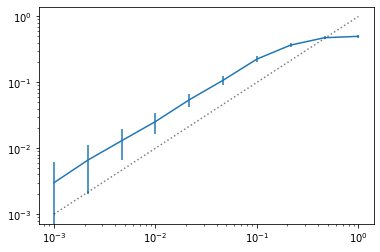

In [17]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 5000
err_dict = {'p': p_phys}

ds = sampler.DirectSampler(ghz, err_dict)
p_L, std = ds.run(n_samples, var=calc.Wilson_var)

plt.xscale('log')
plt.yscale('log')
plt.errorbar(p_phys, p_L, yerr=std)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

Now, we repeat the same plot with the `PECOS` SparseSim instead of our own implementation.

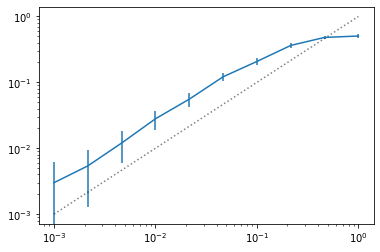

In [20]:
ghz = Circuit([])
ghz.append(('H', 0))
ghz.append(('CNOT', (0,1)))
ghz.append(('CNOT', (1,2)))
ghz.append(('CNOT', (2,3)))
ghz.append(('CNOT', (3,4)))
ghz.append(('CNOT', (0,4)))
ghz.append(('measure Z', 4))

class DirectSamplerDiagnostic(sampler.DirectSampler):
    
    # We need to redefine how to run a circuit, since the PECOS circuit
    # is slightly differently defined.
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim.run_gate(sub_tick[0], {sub_tick[1]})
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim.run_gate(tick[0], {tick[1]})
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim.run_gate(sub_err_tick[0], {sub_err_tick[1]})
                    elif type(err_tick) == tuple:
                        sim.run_gate(err_tick[0], {err_tick[1]})
        return msmts
    
    # Also, we need to adjust run and _sample to accept sim argument
    def run(self, n_samples=100, var=calc.Wilson_var, sim=pc.simulators.SparseSim):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0]))

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(self.err_gen, p_phys, sim)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std 

                        
    def _sample(self, err_gen=None, p_phys=None, sim=None):
        sim = sim(self.n_qubits) # Flexible sim
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

ds = DirectSamplerDiagnostic(ghz, err_dict)
p_L_spsim, std_spsim = ds.run(n_samples=n_samples, var=calc.Wilson_var, sim=pc.simulators.SparseSim)

plt.errorbar(p_phys, p_L_spsim, yerr=std_spsim,);
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);

Also, we can do the simulation with another simulator. `PECOS` implements bindings for the ProjectQ state vector simulator. Let's run the simulation with this sim and compare to the other results.

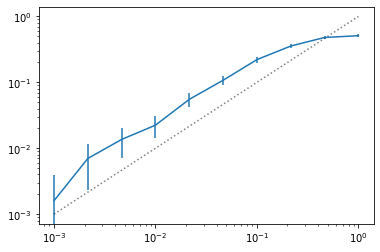

In [21]:
ghz = Circuit([])
ghz.append(('H', 0))
ghz.append(('CNOT', (0,1)))
ghz.append(('CNOT', (1,2)))
ghz.append(('CNOT', (2,3)))
ghz.append(('CNOT', (3,4)))
ghz.append(('CNOT', (0,4)))
ghz.append(('measure Z', 4))

class DirectSamplerDiagnostic(sampler.DirectSampler):
    
    # We need to redefine how to run a circuit, since the PECOS circuit
    # is slightly differently defined.
    def run_circuit(self, sim, circuit, err_circuit):
        msmts = []
        for tick_idx, tick in enumerate(circuit):
            if type(tick) == list:
                for sub_tick in tick:
                    res = sim.run_gate(sub_tick[0], {sub_tick[1]})
                    if res: 
                        msmts.append((tick_idx,res))
            elif type(tick) == tuple:
                res = sim.run_gate(tick[0], {tick[1]})
                if res: 
                    msmts.append((tick_idx,res))
    
            if err_circuit:
                err_tick = err_circuit[tick_idx]
                if err_tick:
                    if type(err_tick) == list:
                        for sub_err_tick in err_tick:
                            sim.run_gate(sub_err_tick[0], {sub_err_tick[1]})
                    elif type(err_tick) == tuple:
                        sim.run_gate(err_tick[0], {err_tick[1]})
        return msmts
    
    # Also, we need to adjust run and _sample to accept sim argument
    def run(self, n_samples=100, var=calc.Wilson_var, sim=pc.simulators.SparseSim):
        fail_cnts = np.zeros((self.p_phys_mat.shape[0]))

        for i, p_phys in enumerate(self.p_phys_mat):
            for _ in range(n_samples):
                msmt = self._sample(self.err_gen, p_phys, sim)
                fail_cnts[i] += self._check_logical_failure(msmt)

        p_L = fail_cnts / n_samples
        std = np.sqrt( var(p_L, n_samples) )
        return p_L, std 

                        
    def _sample(self, err_gen=None, p_phys=None, sim=None):
        sim = sim(self.n_qubits) # Flexible sim
        err_circ = None if err_gen==None else err_gen.generate(self.partitions, p_phys)
        msmt = self.run_circuit(sim, self.circuit, err_circ)
        return msmt

ds = DirectSamplerDiagnostic(ghz, err_dict)
p_L_stvec, std_stvec = ds.run(n_samples=n_samples, var=calc.Wilson_var, sim=pc.simulators.ProjectQSim)

plt.errorbar(p_phys, p_L_stvec, yerr=std_stvec,);
plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);

And plot them together on one plot.

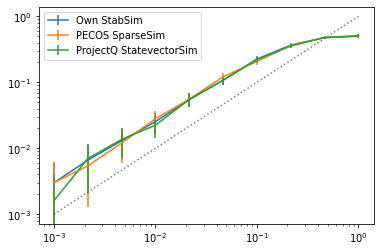

In [22]:
plt.errorbar(p_phys, p_L, yerr=std, label='Own StabSim');
plt.errorbar(p_phys, p_L_spsim, yerr=std_spsim, label='PECOS SparseSim');
plt.errorbar(p_phys, p_L_stvec, yerr=std_stvec, label='ProjectQ StatevectorSim');

plt.xscale('log')
plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5);
plt.legend();

Besides the low-p area, where we have a large variance the three simulation results match very good. Let's check how subset sampling compares to the reference.

[(0,), (1,), (2,)]
[(0,), (1,)]


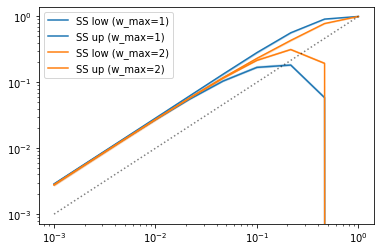

In [12]:
n_samples = 1000
p_phys = np.logspace(-3,0,10)

err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
print(ss._find_weights(p_max=[0.1], delta_max=[0.1])) # weight cutoff 2
print(ss._find_weights(p_max=[0.1], delta_max=[0.2])) # weight cutoff 1

for p_max,d_max,col,w_max in zip([0.1,0.1], [0.2,0.1], ['tab:blue', 'tab:orange'],[1,2]):
    p_L_up, p_L_low, std = ss.run(p_max=[p_max], delta_max=[d_max], n_samples=n_samples, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)
    plt.plot(p_phys, p_L_low, label="SS low (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2, color=col)
    plt.plot(p_phys, p_L_up, label="SS up (w_max=%s)"%w_max, c=col)
    plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2, color=col)
    plt.xscale('log')
    plt.yscale('log')
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)
plt.legend()

This looks very similar to what we got in the reference.

CPU times: user 19.4 s, sys: 0 ns, total: 19.4 s
Wall time: 19.4 s


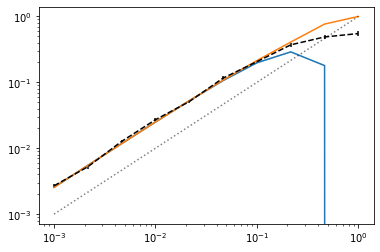

In [13]:
%%time

p_phys = np.logspace(-3,0,10)
n_samples = 100
sample_range = np.int_(n_samples / p_phys)
p_Ls = []
stds = []

for p,n in zip(p_phys,sample_range):  
    err_dict = {'p': p}
    ds = sampler.DirectSampler(ghz, err_dict)
    p_L, std = ds.run(n, var=calc.Wald_var)
    p_Ls.append(p_L)
    stds.append(std)
p_Ls = np.array(p_Ls).flatten()
stds = np.array(stds).flatten()
    
err_dict = {'p': p_phys}
ss = sampler.SubsetSampler(ghz, err_dict)
p_L_up, p_L_low, std = ss.run(p_max=[0.1], delta_max=[0.1], n_samples=1000, var=calc.Wald_var, SS_sel_fn=calc.balanced_SS_selector)

plt.errorbar(p_phys, p_Ls, fmt='--', c="black", yerr=stds)
plt.plot(p_phys, p_L_low)
plt.fill_between(p_phys, p_L_low-std, p_L_low+std, alpha=0.2)
plt.plot(p_phys, p_L_up)
plt.fill_between(p_phys, p_L_up-std, p_L_up+std, alpha=0.2)
plt.plot(p_phys, p_phys, 'k:', alpha=0.5)

plt.xscale('log')
plt.yscale('log')

Also the comparison plot looks good.

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 4.53 µs


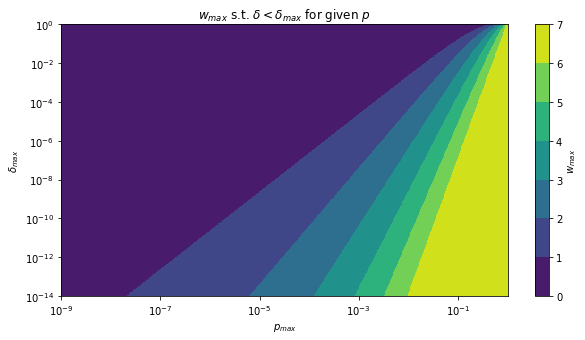

In [14]:
%time

n_gates = len(ghz)

ps = np.logspace(-9, 0, 500) # physical error rates
ds = np.logspace(-14, 0, 500)

Z = [[calc.weight_cutoff(p_max, d_max, n_gates) for p_max in ps] for d_max in ds]

plt.figure(figsize=(10,5))
plt.contourf(ps, ds, Z)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('$p_{max}$')
plt.ylabel('$\delta_{max}$')
plt.colorbar(label="$w_{max}$")
plt.title('$w_{max}$ s.t. $\delta<\delta_{max}$ for given $p$');
plt.show()

The $w_{max}$ selector is identical to the procedure used in the reference. Next, we check multi-parameter noise models.